# Content

__1. Exploratory Visualization__  
__2. Data Cleaning__  
__3. Feature Engineering__  
__4. Modeling & Evaluation__  
__5. Ensemble Methods__  

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('dark_background')

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [88]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [89]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# Exploratory Visualization

+ __It seems that the price of recent-built houses are higher. So later I 'll use labelencoder for three "Year" feature.__

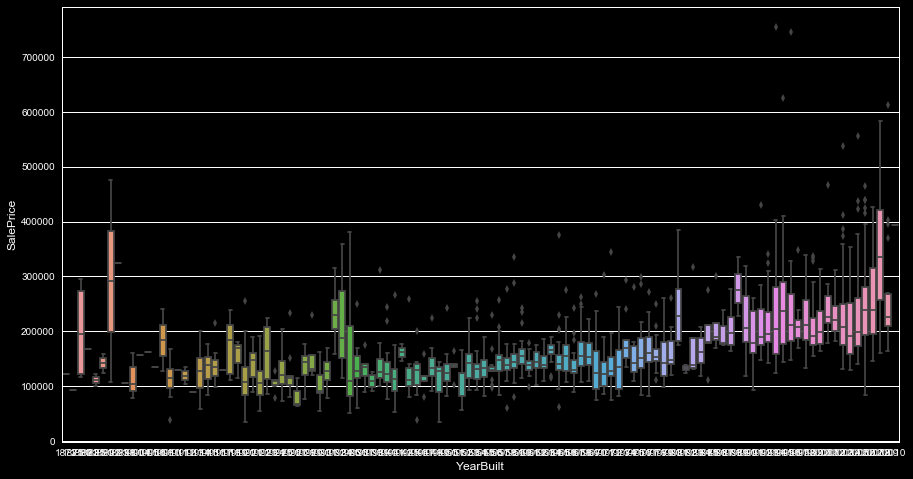

In [90]:
plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

+ __As is discussed in other kernels, the bottom right two two points with extremely large GrLivArea are likely to be outliers. So we delete them.__

(0, 800000)

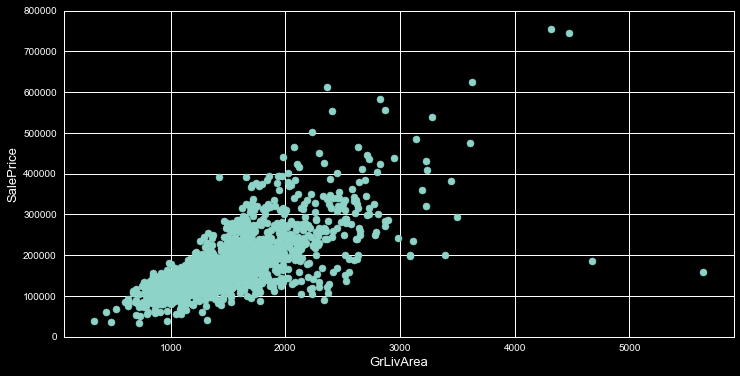

In [91]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [9]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

In [10]:
full=pd.concat([train,test], ignore_index=True)

In [11]:
full.drop(['Id'],axis=1, inplace=True)
full.shape

(2917, 80)

# Data Cleaning

### Missing Data

In [12]:
aa = full.isnull().sum()
aa[aa>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

+ __Let's first imput the missing values of LotFrontage based on the median of LotArea and Neighborhood. Since LotArea is a continuous feature, We use qcut to divide it into 10 parts.__

In [14]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [15]:
full["LotAreaCut"] = pd.qcut(full.LotArea,10)

In [16]:
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [17]:
full['LotFrontage']=full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [18]:
# Since some combinations of LotArea and Neighborhood are not available, so we just LotAreaCut alone.
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

+ __Then we filling in other missing values according to data_description.__

In [19]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

In [20]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

In [21]:
# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

+ __And there is no missing data except for the value we want to predict !__

In [22]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

# Feature Engineering

+ __Convert some numerical features into categorical features. It's better to use LabelEncoder and get_dummies for these features.__

In [23]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

+ __Now I want to do a long list of value-mapping. __
+ __I was influenced by the insight that we should build as many features as possible and trust the model to choose the right features. So I decided to groupby SalePrice according to one feature and sort it based on mean and median. Here is an example:__

In [24]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

+ __So basically I'll do__  
                '180' : 1
                '30' : 2   '45' : 2
                '190' : 3, '50' : 3, '90' : 3,
                '85' : 4, '40' : 4, '160' : 4
                '70' : 5, '20' : 5, '75' : 5, '80' : 5, '150' : 5
                '120': 6, '60' : 6

+ __Different people may have different views on how to map these values, so just follow your instinct =^_^=__  
__Below I also add a small "o" in front of the features so as to keep the original features to use get_dummies in a moment.__

In [25]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"

In [26]:
map_values()

'Done!'

In [27]:
# drop two unwanted columns
full.drop("LotAreaCut",axis=1,inplace=True)
full.drop(['SalePrice'],axis=1,inplace=True)

## Pipeline

+ __Next we can build a pipeline. It's convenient to experiment different feature combinations once you've got a pipeline.__

+ __Label Encoding three "Year" features.__

In [28]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

+ __Apply log1p to the skewed features, then get_dummies.__

In [29]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [30]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [31]:
# save the original data for later use
full2 = full.copy()

In [32]:
data_pipe = pipe.fit_transform(full2)

In [33]:
data_pipe.shape

(2917, 405)

In [35]:
data_pipe.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,854,0.0,706.0,0.0,150.0,0.000000,0,2,548.0,...,1,0,1,1,0,0,0,1,0,0
1,7.141245,0,0.0,978.0,0.0,284.0,0.000000,1,2,460.0,...,1,0,1,1,0,0,1,0,0,0
2,6.825460,866,0.0,486.0,0.0,434.0,0.000000,1,2,608.0,...,1,0,1,1,0,0,0,1,0,0
3,6.869014,756,0.0,216.0,0.0,540.0,5.609472,1,1,642.0,...,1,0,1,1,0,1,0,0,0,0
4,7.044033,1053,0.0,655.0,0.0,490.0,0.000000,1,2,836.0,...,1,0,1,1,0,0,0,1,0,0


+ __use robustscaler since maybe there are other outliers.__

In [36]:
scaler = RobustScaler()

In [37]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

## Feature Selection

+ __I have to confess, the feature engineering above is not enough, so we need more.__   
+ __Combining different features is usually a good way, but we have no idea what features should we choose. Luckily there are some models that can provide feature selection, here I use Lasso, but you are free to choose Ridge, RandomForest or GradientBoostingTree.__

In [38]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

In [40]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,0.108870
OverallQual,0.102583
2ndFlrSF,0.074221
YearBuilt,0.068926
1stFlrSF,0.059760
Functional_Typ,0.051862
TotalBsmtSF,0.050261
Neighborhood_Crawfor,0.049942
OverallCond,0.045527
oNeighborhood,0.044311


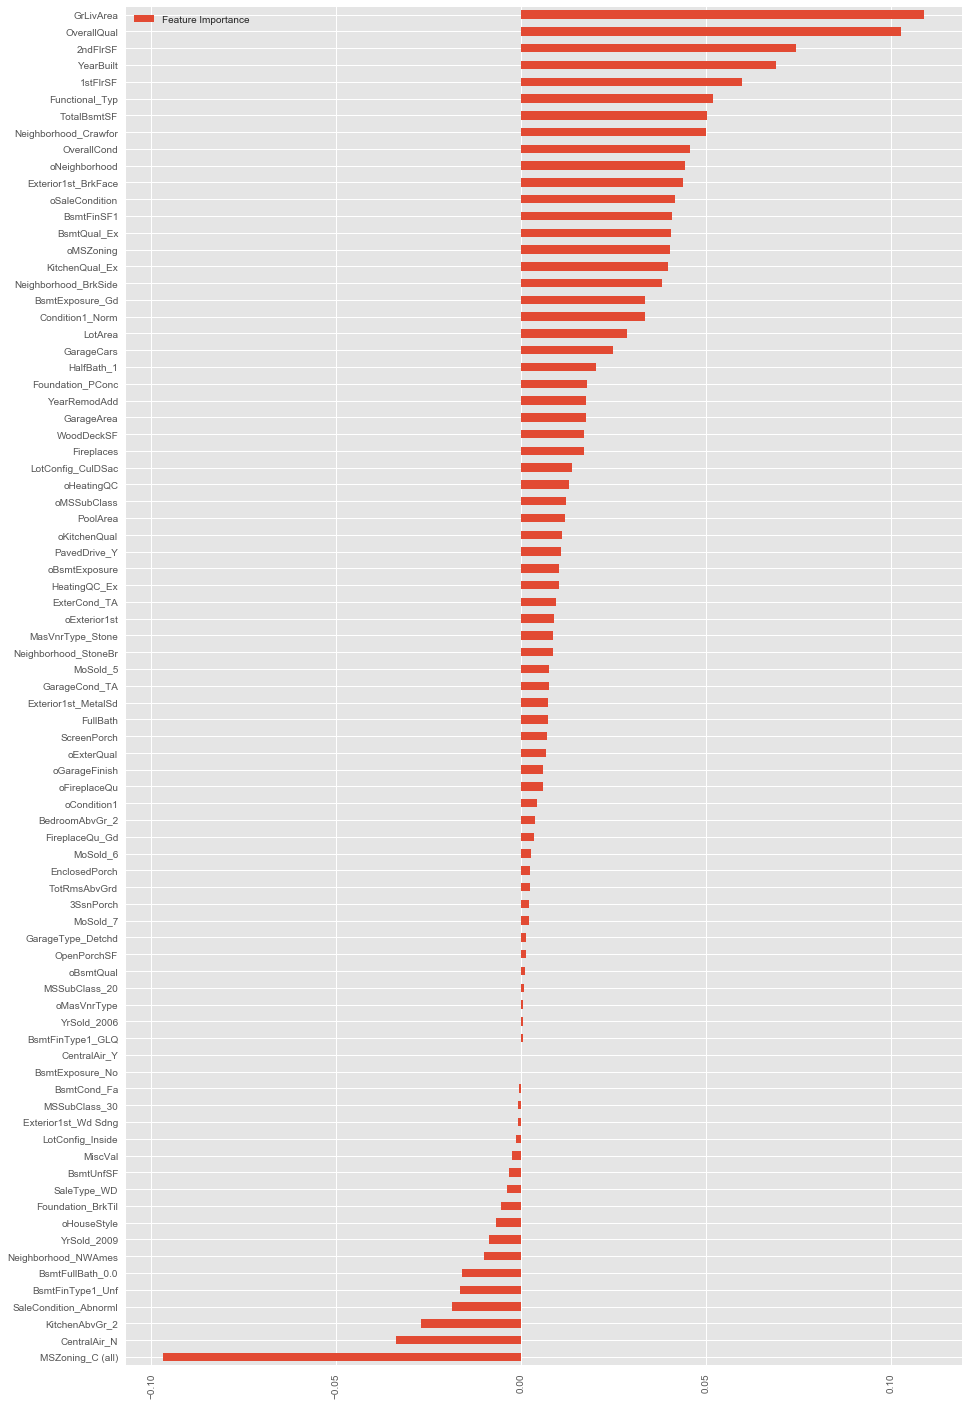

In [41]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

+ __Based on the "Feature Importance" plot and other try-and-error, I decided to add some features to the pipeline.__

In [42]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

+ __By using a pipeline, you can quickily experiment different feature combinations.__

In [43]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

## PCA

+ __Im my case, doing PCA is very important. It lets me gain a relatively big boost on leaderboard. At first I don't believe PCA can help me, but 
in retrospect, maybe the reason is that the features I built are highly correlated, and it leads to multicollinearity. PCA can decorrelate these features.__

+ __So I'll use approximately the same dimension in PCA as  in the original data. Since the aim here is not deminsion reduction.__

In [44]:
full_pipe = pipe.fit_transform(full)

In [45]:
full_pipe.shape

(2917, 426)

In [46]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [52]:
pca = PCA(n_components=410)

In [53]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [54]:
X_scaled.shape, test_X_scaled.shape

((1458, 410), (1459, 410))

# Modeling & Evaluation

In [55]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

+ __We choose 13 models and use 5-folds cross-calidation to evaluate these models.__

Models include:

+ LinearRegression
+ Ridge
+ Lasso
+ Random Forrest
+ Gradient Boosting Tree
+ Support Vector Regression
+ Linear Support Vector Regression
+ ElasticNet
+ Stochastic Gradient Descent
+ BayesianRidge
+ KernelRidge
+ ExtraTreesRegressor
+ XgBoost

In [57]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

TypeError: __init__() got an unexpected keyword argument 'max_iter'

In [58]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

NameError: name 'models' is not defined

+ __Next we do some hyperparameters tuning. First define a gridsearch method.__

In [59]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

### Lasso

In [60]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.111296607965
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111463        0.001392
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111297        0.001339
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111538        0.001284
3  {'alpha': 0.0009, 'max_iter': 10000}         0.111915        0.001206


### Ridge

In [61]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.110201749615
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110375        0.001268
1  {'alpha': 40}         0.110305        0.001249
2  {'alpha': 45}         0.110258        0.001235
3  {'alpha': 50}         0.110227        0.001223
4  {'alpha': 55}         0.110209        0.001213
5  {'alpha': 60}         0.110202        0.001205
6  {'alpha': 65}         0.110203        0.001198
7  {'alpha': 70}         0.110212        0.001192
8  {'alpha': 80}         0.110247        0.001184
9  {'alpha': 90}         0.110301        0.001178


### SVR

In [62]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.108231959163
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108661   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108312   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108650   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108297   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108562   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108248   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108555   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108232   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108474   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108248   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108444   
11  {'C': 15, 'epsilon': 0.009, 'ga

### Kernel Ridge

In [63]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.108269736148
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.108270   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.108509   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.108399   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.108278   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.108762   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.108299   

   std_test_score  
0        0.001209  
1        0.001243  
2        0.001189  
3        0.001210  
4        0.001181  
5        0.001191  


### ElasticNet

In [64]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.111171351585
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.114762   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.114250   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.112062   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111278   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.111209   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.112483   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.111171   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.111192   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.112983   

   std_test_score  
0        0.001937  
1        0.001904  
2        0.001596  
3        0.001382  
4        0.001326  
5        0.001160  
6        0.001312  
7        0.001277  
8        0.001159  


# Ensemble Methods 

### Weight Average

+ __Average base models according to their weights.__

In [65]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [66]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [67]:
# assign weights based on their gridsearch score
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [68]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [69]:
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10768459878


+ __But if we average only two best models, we gain better cross-validation score.__

In [70]:
weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])

In [71]:
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.106683495872


## Stacking

+ __Aside from normal stacking, I also add the "get_oof" method, because later I'll combine features generated from stacking and original features.__

In [72]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

+ __Let's first try it out ! It's a bit slow to run this method, since the process is quite compliated. __

In [73]:
# must do imputer first, otherwise stacking won't work, and i don't know why.
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [74]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [75]:
score = rmse_cv(stack_model,a,b)
print(score.mean())

0.106575710581


+ __Next we extract the features generated from stacking, then combine them with original features.__

In [76]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)

In [77]:
X_train_stack.shape, a.shape

((1458, 6), (1458, 410))

In [78]:
X_train_add = np.hstack((a,X_train_stack))

In [79]:
X_test_add = np.hstack((test_X_scaled,X_test_stack))

In [80]:
X_train_add.shape, X_test_add.shape

((1458, 416), (1459, 416))

In [81]:
score = rmse_cv(stack_model,X_train_add,b)
print(score.mean())

0.101824684864


+ __You can even do parameter tuning for your meta model after you get "X_train_stack", or do it after combining with the original features. but that's a lot of work too !__

### Submission

In [82]:
# This is the final model I use
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [83]:
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [84]:
pred = np.exp(stack_model.predict(test_X_scaled))

In [85]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)